## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [4]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [5]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [6]:
len(fmnist_dataset_test)

10000

In [7]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


##### Let's check what si train data with labels

In [33]:
def plot_from_batch_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    for i in range(grid_size[0] * grid_size[1]):
        
        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])
        
        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(batch_image_ndarray, 0, 1)
        
        # display batch samples with labels
        sample_title = 'Label = %d' % (label_batch[i].item())
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src, cmap='gray')
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    pass

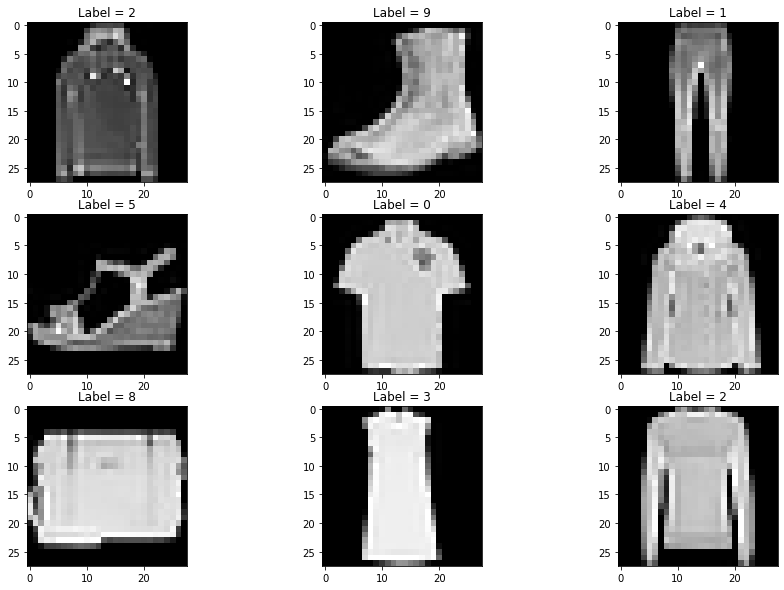

In [34]:
plot_from_batch_generator(train_loader)

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [14]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [15]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                   [-1, 64]          16,448
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 16]           1,040
              ReLU-7                   [-1, 16]               0
            Linear-8                   [-1, 10]             170
 TinyNeuralNetwork-9                   [-1, 10]               0
Total params: 218,618
Trainable params: 218,618
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.83
Estimated Total Size (MB): 0.85
-------------------------------------------

(tensor(218618), tensor(218618))

Your experiments come here:

In [46]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

In [19]:
from sklearn.metrics import accuracy_score
import time
from tqdm.auto import tqdm

In [29]:
from torch.utils.tensorboard import SummaryWriter

In [49]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    # Writer will output to ./runs/ directory by default
    writer = SummaryWriter()
    
    train_loss_sum = 0
    val_loss_sum = 0
    
    for epoch in tqdm(range(n_epochs)):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()
        
        model.train(True)
        for X_batch, y_batch in train_loader:
            opt.zero_grad()
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(X_batch)
            
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            opt.step()
            
            ep_train_loss.append(loss.item())
            
        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                predictions = model(X_batch)
                
                loss = loss_fn(predictions, y_batch)
                
                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1].data
                ep_val_accuracy.append(accuracy_score(y_batch.cpu().numpy(), y_pred.cpu().numpy()))
                
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')
        
        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        train_loss_sum += train_loss[-1]
        writer.add_scalar('Loss/train', train_loss_sum, epoch)

        val_loss_sum += val_loss[-1]
        writer.add_scalar('Loss/val', val_loss_sum, epoch)
                
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")
    
    writer.close()

    return train_loss, val_loss, val_accuracy

In [50]:
n_epoches = 5

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func,opt, n_epoches)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 of 5 took 7.912s
	  training loss: 0.687322
	validation loss: 0.472266
	validation accuracy: 0.838
Epoch 2 of 5 took 7.956s
	  training loss: 0.424012
	validation loss: 0.463255
	validation accuracy: 0.840
Epoch 3 of 5 took 8.109s
	  training loss: 0.377292
	validation loss: 0.384263
	validation accuracy: 0.864
Epoch 4 of 5 took 7.525s
	  training loss: 0.347810
	validation loss: 0.373601
	validation accuracy: 0.866
Epoch 5 of 5 took 7.707s
	  training loss: 0.328196
	validation loss: 0.366894
	validation accuracy: 0.870


In [22]:
from matplotlib import pyplot as plt

In [47]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    print(f'Max accurasy score: {max(val_accuracy)} at {np.argmax(val_accuracy)} epoch')
    
    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)
    axes[1].plot(np.argmax(val_accuracy), max(val_accuracy), 'ro')

Max accurasy score: 0.8953125 at 4 epoch


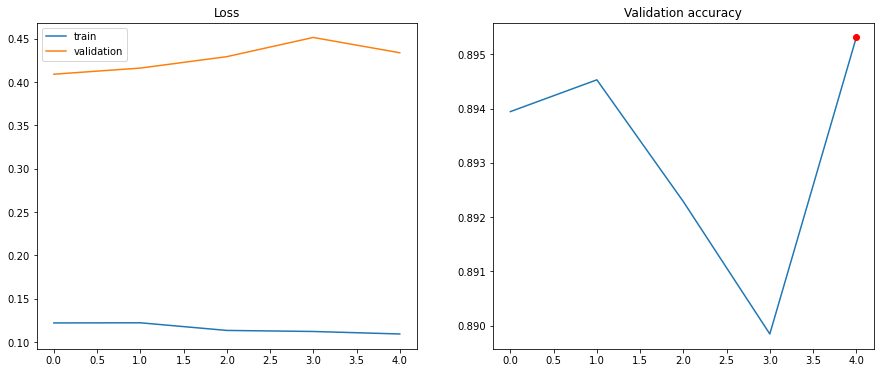

In [48]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [55]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 258),
            nn.ReLU(),
            nn.Linear(258, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [56]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 258]         132,354
              ReLU-5                  [-1, 258]               0
            Linear-6                  [-1, 128]          33,152
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 32]           4,128
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
OverfittingNeuralNetwork-11                   [-1, 10]               0
Total params: 571,884
Trainable params: 571,884
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
F

(tensor(571884), tensor(571884))

In [57]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [58]:
indices = torch.arange(10000)
dataset_train_decr = torch.utils.data.Subset(fmnist_dataset_train, indices)

train_loader_decr = torch.utils.data.DataLoader(dataset_train_decr, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

In [59]:
n_epoches = 20

train_loss, val_loss, val_accuracy = train_model(model, train_loader_decr, test_loader, loss_func,opt, n_epoches)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 of 20 took 5.844s
	  training loss: 1.157114
	validation loss: 0.850444
	validation accuracy: 0.686
Epoch 2 of 20 took 5.668s
	  training loss: 0.665667
	validation loss: 0.720909
	validation accuracy: 0.727
Epoch 3 of 20 took 5.321s
	  training loss: 0.559053
	validation loss: 0.563879
	validation accuracy: 0.797
Epoch 4 of 20 took 5.372s
	  training loss: 0.486478
	validation loss: 0.514622
	validation accuracy: 0.814
Epoch 5 of 20 took 5.392s
	  training loss: 0.434303
	validation loss: 0.505368
	validation accuracy: 0.822
Epoch 6 of 20 took 5.340s
	  training loss: 0.404950
	validation loss: 0.504506
	validation accuracy: 0.819
Epoch 7 of 20 took 5.376s
	  training loss: 0.368791
	validation loss: 0.487356
	validation accuracy: 0.828
Epoch 8 of 20 took 5.657s
	  training loss: 0.355067
	validation loss: 0.475612
	validation accuracy: 0.830
Epoch 9 of 20 took 5.504s
	  training loss: 0.339084
	validation loss: 0.435839
	validation accuracy: 0.847
Epoch 10 of 20 took 5.472s
	

Max accurasy score: 0.8591796875 at 17 epoch


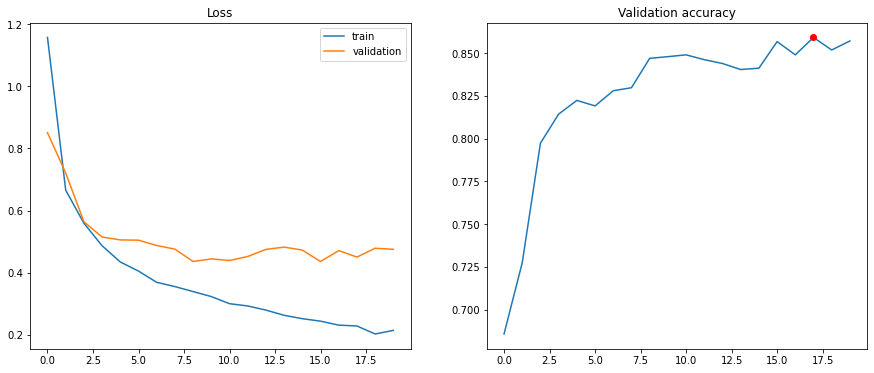

In [60]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [148]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 258),
            nn.ReLU(),
            nn.Linear(258, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [149]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 258]         132,354
              ReLU-5                  [-1, 258]               0
            Linear-6                  [-1, 128]          33,152
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 32]           2,080
             ReLU-11                   [-1, 32]               0
           Linear-12                   [-1, 16]             528
             ReLU-13                   [-1, 16]               0
           Linear-14                   

(tensor(578460), tensor(578460))

In [150]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [151]:
n_epoches = 20

train_loss, val_loss, val_accuracy = train_model(model, train_loader_decr, test_loader, loss_func,opt, n_epoches)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 of 20 took 6.323s
	  training loss: 1.516979
	validation loss: 0.910287
	validation accuracy: 0.612
Epoch 2 of 20 took 5.909s
	  training loss: 0.860085
	validation loss: 0.762152
	validation accuracy: 0.678
Epoch 3 of 20 took 5.600s
	  training loss: 0.735707
	validation loss: 0.663923
	validation accuracy: 0.750
Epoch 4 of 20 took 5.871s
	  training loss: 0.596479
	validation loss: 0.591091
	validation accuracy: 0.784
Epoch 5 of 20 took 5.895s
	  training loss: 0.536747
	validation loss: 0.572587
	validation accuracy: 0.791
Epoch 6 of 20 took 7.036s
	  training loss: 0.491219
	validation loss: 0.554339
	validation accuracy: 0.805
Epoch 7 of 20 took 6.649s
	  training loss: 0.473084
	validation loss: 0.538321
	validation accuracy: 0.809
Epoch 8 of 20 took 6.634s
	  training loss: 0.447817
	validation loss: 0.531307
	validation accuracy: 0.808
Epoch 9 of 20 took 6.759s
	  training loss: 0.430825
	validation loss: 0.526146
	validation accuracy: 0.816
Epoch 10 of 20 took 6.606s
	

Max accurasy score: 0.85078125 at 19 epoch


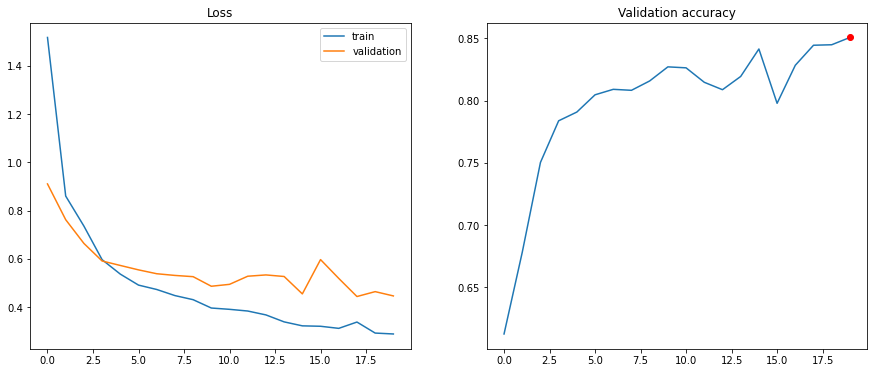

In [152]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Conclusions:
BatchNorm and Dropout is a good practice to avoid 